# Projeto 5

## Bibliotecas e funções base

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def imagem_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
def calculateOtsuVariables(hist_norm):
    Q = hist_norm.cumsum()
    size = len(Q)
    bins = np.arange(size)
    
    fn_min = np.inf
    
    thresh = -1
    otsuMedian = [-1, -1]
    otsuDev = [-1, -1]
    
    for i in range(1, size):
        p1, p2 = np.hsplit(hist_norm, [i])  # probabilities
        q1, q2 = max(Q[i], 0.00000001), max(Q[size - 1] - Q[i], 0.00000001)  # cum sum of classes
        b1, b2 = np.hsplit(bins, [i])  # weights
        
        # finding means and variances
        m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
        v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2
        
        # Calculates the minimization function
        fn = v1 * q1 + v2 * q2
        
        if fn < fn_min:
            fn_min = fn
            thresh = i
            otsuMedian[0] = m1
            otsuMedian[1] = m2
            otsuDev[0] = np.sqrt(v1)
            otsuDev[1] = np.sqrt(v2)

    return(otsuMedian, otsuDev, thresh)

## Abrir a imagem

Todas imagens serão abertas no padrão BGR pelo OpenCV, sendo assim podemos alterar esse formato para facilitar nosso trabalho.

Primeiro, vamos conveter todas imagens para o padrão RGB para funcionar com o _matplotlib.pyplot_.

Outros formatos que vamos adotar são os HLS e HSV para facilitar em algumas operações.

In [4]:
# Nome da imagem
IMGS = ["input/{0}.bmp".format(i) for i in range(0, 10)]

# Abrindo a imagem
imgs = [cv2.imread(name) for name in IMGS]

background = cv2.cvtColor(cv2.imread("input/background1.bmp"), cv2.COLOR_BGR2RGB)

# Converter para RGB
RGB_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
HLS_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HLS) for img in imgs]
HSV_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in imgs]
MASK_imgs = [np.zeros(img.shape).astype(float) for img in RGB_imgs]

## Tratar imagem

### Histogramas das distâncias euclidianas

A ideia é calcular uma distância de cada um dos pixel para um pixel verde de referência e então estudar o histograma desses valores.

A partir dos resultados, tentar utilizado o algoritmo de Otsu para obter um threshold que tente dividir as distâncias pequenas (prováveis pixels verdes do chroma key) das demais.

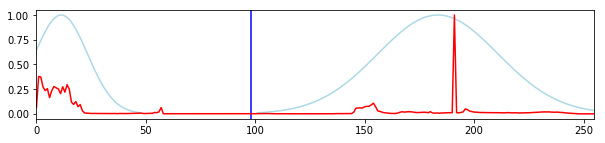

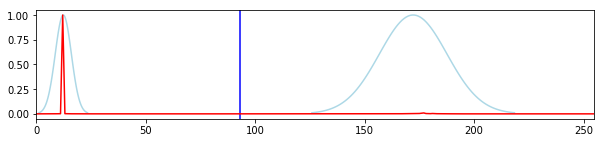

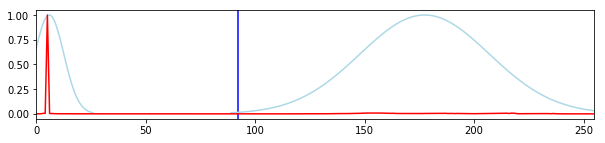

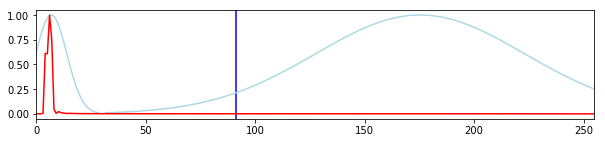

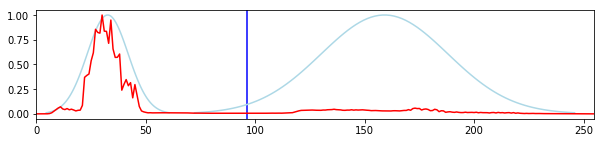

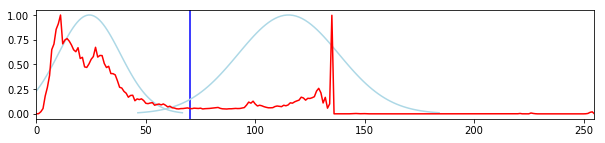

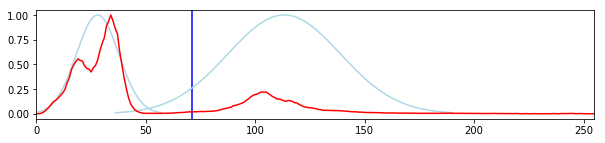

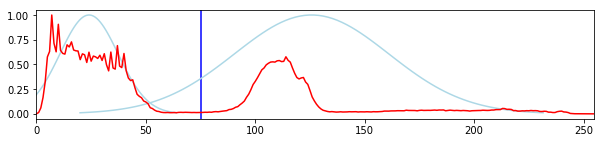

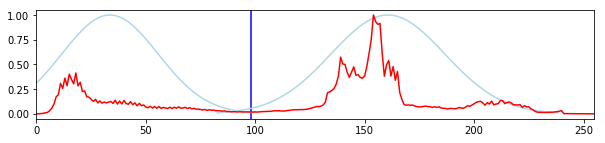

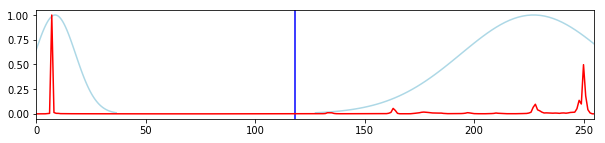

In [32]:
def calc_distance(rgb_img):
    blur = cv2.GaussianBlur(rgb_img, (5,5), 0).astype('float32')
    # Distâncias euclidianas para o pixel verde referência
    green_pixel = [0.0, 255.0, 0.0]
    r_distance = ( green_pixel[0] - blur[:,:,0] ) ** 2
    g_distance = ( green_pixel[1] - blur[:,:,1] ) ** 2
    b_distance = ( green_pixel[2] - blur[:,:,2] ) ** 2
    distances = np.sqrt( r_distance + g_distance + b_distance )
    
    # Normalizar os valores entre 0 e 255
    normalized = cv2.normalize(distances, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # normalized = 255.0 * distances / distances.max()
    return normalized
    
for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):
    
    # Calcular distâncias normalizadas
    normalized = calc_distance(rgb_img)
    
    # Histograma das distâncias
    hist = cv2.calcHist([normalized], [0], None, [256], [0, 256])
    histNorm = hist.ravel() / hist.max()
    # Calcular threshold por Otsu
    [med1, med2], [sigma1, sigma2], thresh = calculateOtsuVariables(histNorm)
    
    # Prepar plot
    fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharex=True, sharey=True)
    axes.set_xlim([0, 255])
    
    # Plot threshold
    axes.axvline(thresh, color="blue")
    # Plot gaussiana 1
    x1 = np.linspace(med1 - 3 * sigma1, med1 + 3 * sigma1, 100)
    y1 = stats.norm.pdf(x1, med1, sigma1)
    axes.plot(x1, y1 / y1.max(), color="lightblue")
    # Plot gaussiana 2
    x2 = np.linspace(med2 - 3 * sigma2, med2 + 3 * sigma2, 100)
    y2 = stats.norm.pdf(x2, med2, sigma2)
    axes.plot(x2, y2 / y2.max(), color="lightblue")
    # Plot histograma
    axes.plot(histNorm, color="red", label="Distâncias")
    
    plt.show()

### Preparar a máscara

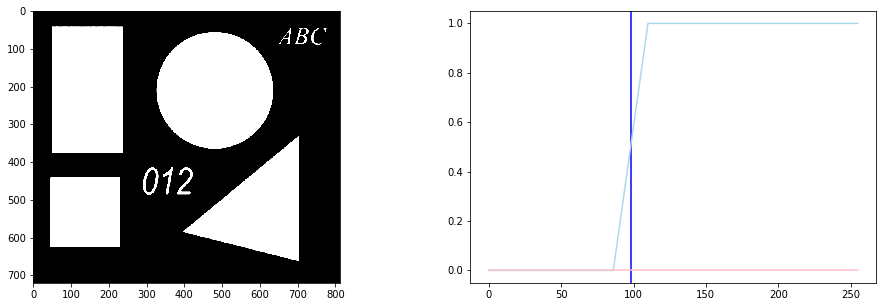

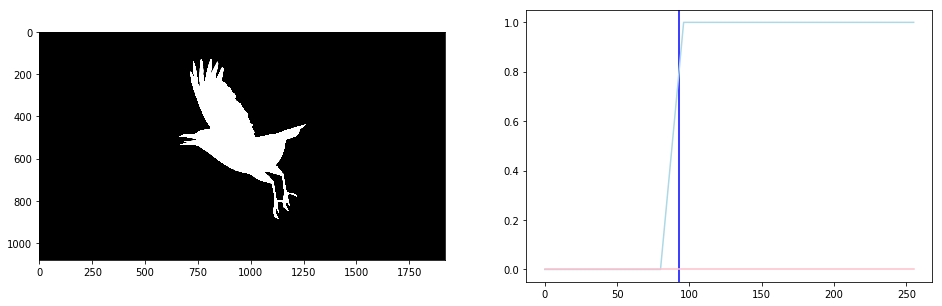

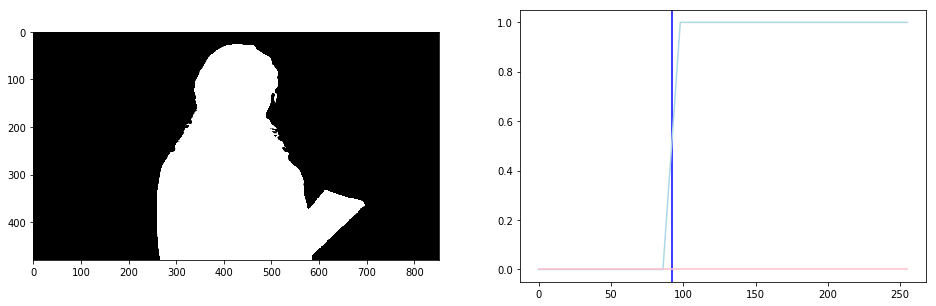

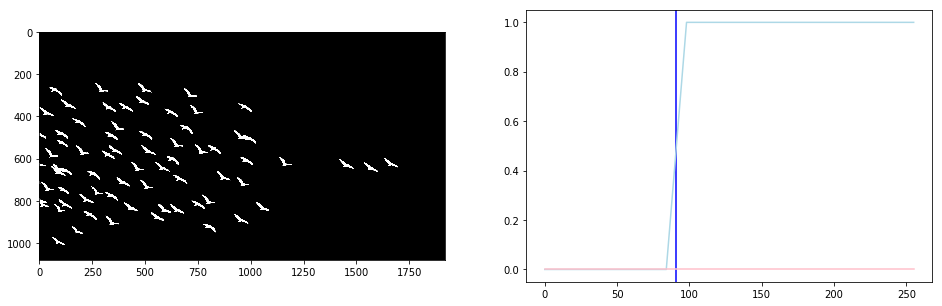

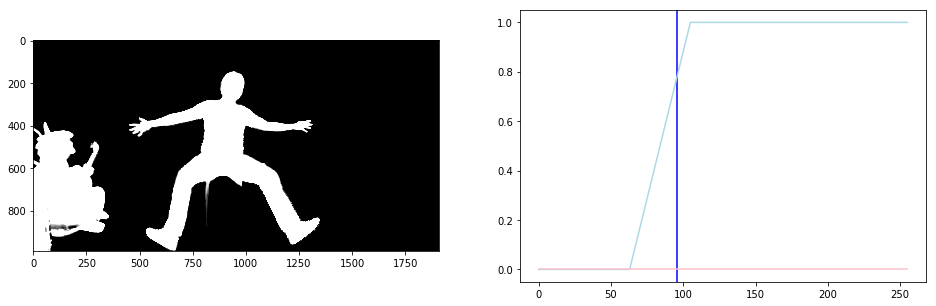

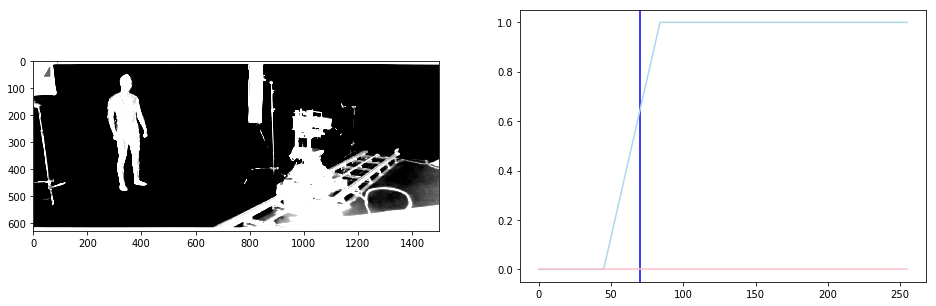

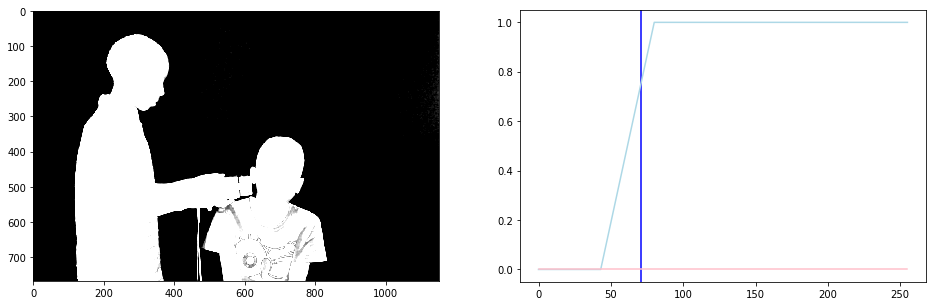

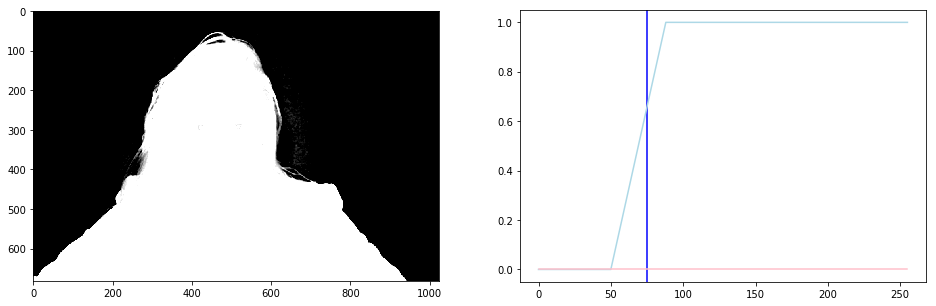

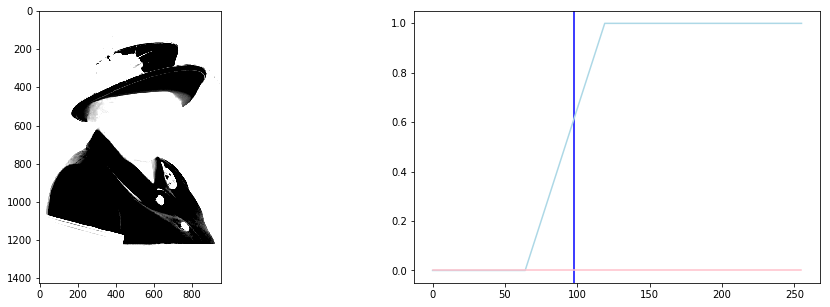

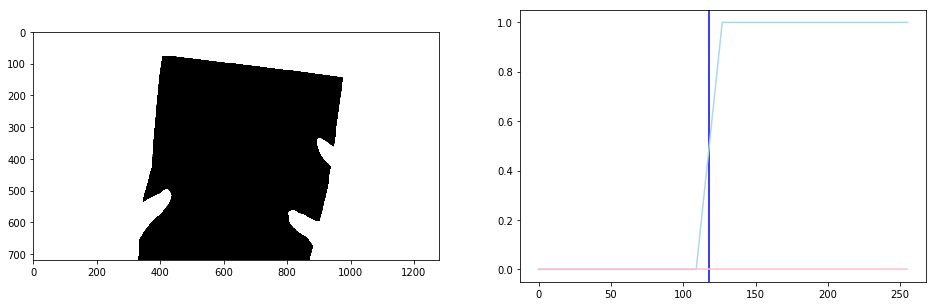

In [33]:
thresholds=[]

for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):
    
    # Calcular distâncias normalizadas
    normalized = calc_distance(rgb_img)
    
    # Histograma das distâncias
    hist = cv2.calcHist([normalized], [0], None, [256], [0, 256])
    histNorm = hist.ravel() / hist.max()
    # Calcular threshold por Otsu
    [med1, med2], [sigma1, sigma2], thresh = calculateOtsuVariables(histNorm)
    
    # Montar uma rampa baseado na gaussiana 1
    # Quanto mais med1, mais do chroma key vamos pegar
    th_inf = int(thresh - med1)
    # Quanto mais sigma1, mais do foreground vamos pegar
    th_sup = int(thresh + sigma1)
    alpha = np.arange(0, 256, dtype='float32')
    
    alpha2 = np.zeros(256, dtype='float32')
    
    alpha[th_inf:th_sup] = ( alpha[th_inf:th_sup] - th_inf ) / (th_sup - th_inf)
    alpha[:th_inf] = 0.0
    alpha[th_sup:] = 1.0
    
    #deviation = sigma1 * 2/3
    #alpha[thresh:int(thresh+deviation)] = 1/(deviation)*(alpha[thresh:int(thresh+deviation)] - (thresh - deviation))
    #alpha[:thresh] = 0.0
    #alpha[int(thresh+deviation):] = 1.0
    
    mask.fill(0.0)
    mask[:,:,0] = mask[:,:,1] = mask[:,:,2] = alpha[np.uint8(normalized[:,:])]
    
    thresholds.append({ 'alpha': alpha, 'sigma': sigma1, 'med': med1, 'thresh': thresh })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    # Plot imagem
    ax1.imshow((mask * 255).astype('uint8'))
    # Plot gráfico
    ax2.axvline(thresh, color="blue")
    ax2.plot(alpha, color="lightblue")
    ax2.plot(alpha2, color="pink")
    plt.show()

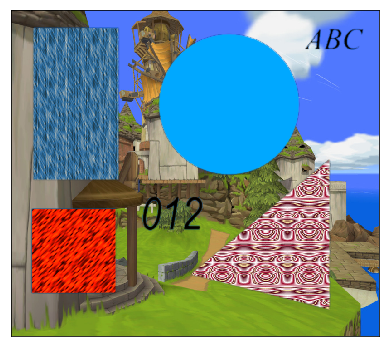

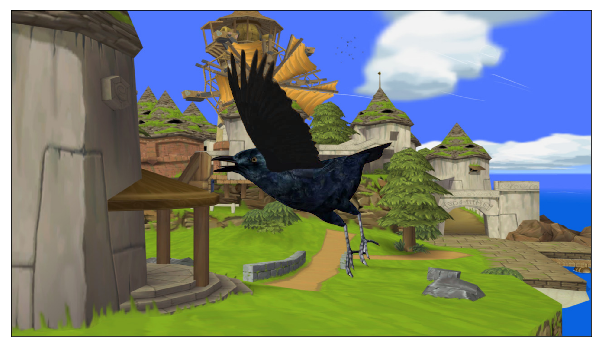

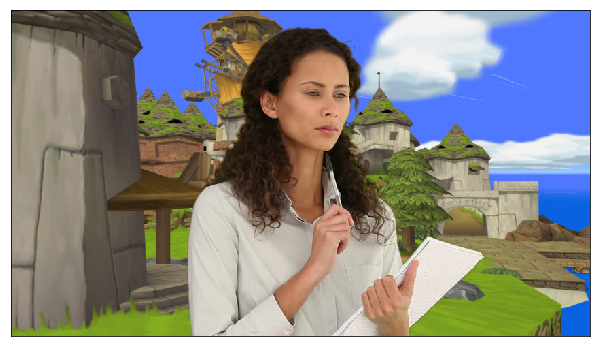

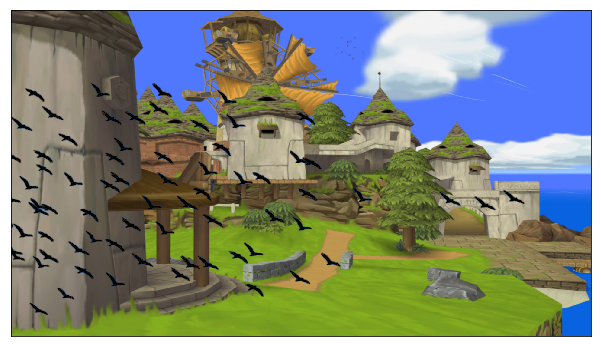

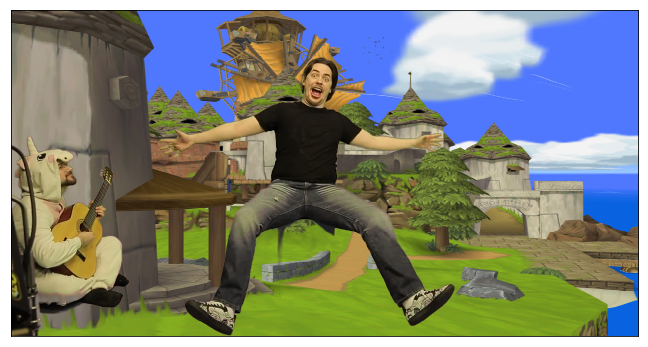

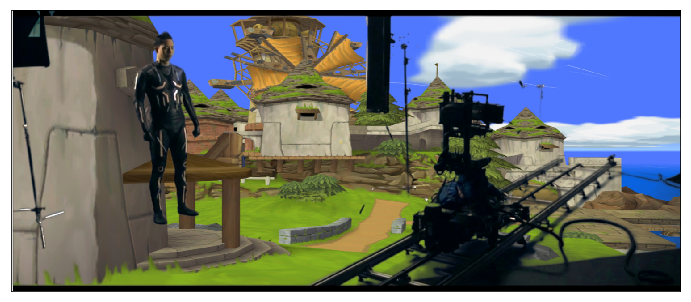

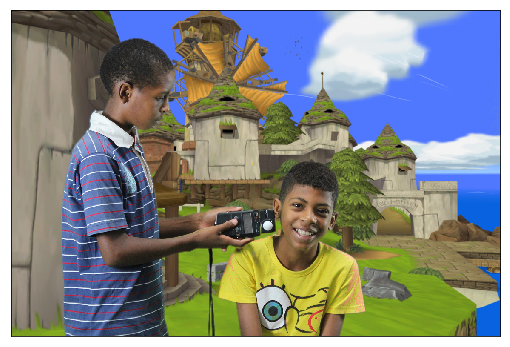

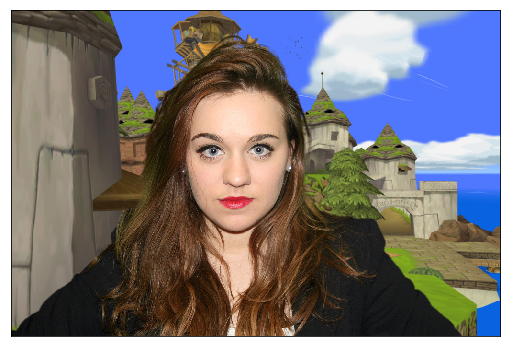

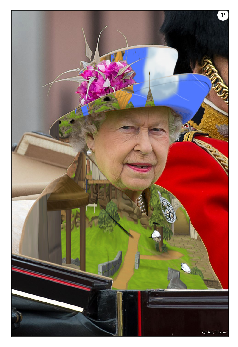

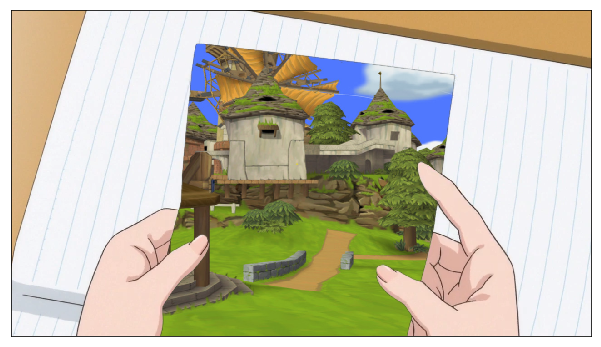

In [73]:
for rgb_img, hls_img, hsv_img, mask, threshold in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs, thresholds):
    # Calcular distâncias normalizadas
    normalized = calc_distance(rgb_img)
    
    # Recurar dados
    alpha = threshold['alpha']
    sigma = threshold['sigma']
    med = threshold['med']
    thresh = threshold['thresh']
    
    mask_blur = cv2.GaussianBlur(mask, (5,5), 0)
    mask = cv2.addWeighted(mask_blur, 1.5, mask, -0.5, 0).clip(min=0, max=1)
    
    # Preparar imagens
    fg = rgb_img.copy().astype(float)
    bg = background.copy().astype(float)
    bg = cv2.resize(bg, (fg.shape[1], fg.shape[0]))
    
    # Multiply the foreground with the alpha matte
    fgmask = mask.copy()
    fg = cv2.multiply(fgmask, fg)
    
    # Tirar os verdes restantes
    cond = np.all([fgmask[:,:,0] > 0,
                   hsv_img[:,:,0] > 30, 
                   hsv_img[:,:,0] < 90, 
                   hsv_img[:,:,1] > 0.4, 
                   hsv_img[:,:,0] > 0.3], axis=0).reshape(fg[:,:,0].shape)
    brighting = (fg[cond, 0] + fg[cond, 1] + fg[cond, 2])
    fg[cond, 1] = (fg[cond, 0] + fg[cond, 2])/2
    pos_filter = np.maximum(fg[cond, 0] + fg[cond, 1] + fg[cond, 2], np.full(fg[cond, 0].shape, 3))
    fg[cond,0] *= (brighting/pos_filter).reshape(fg[cond,0].shape)
    fg[cond,1] *= (brighting/pos_filter).reshape(fg[cond,0].shape)
    fg[cond,2] *= (brighting/pos_filter).reshape(fg[cond,0].shape)
    fg = fg.clip(min=0, max=255)

    # Multiply the background with ( 1 - alpha )
    bgmask = 1.0 - mask.copy()
    bg = cv2.multiply(bgmask, bg)

    # Add the masked foreground and background.
    outImage = cv2.add(fg, bg)

    imagem_plot(outImage.clip(min=0, max=255).astype(int))